In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline
import numpy as np

### Starting Point and Troubles
Our starting point is going to be very similar to our ending point in the last notebook. However, there are a couple things we've cleaned up and added to showcase problems

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocabsize = len(stoi)

In [4]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return(X,Y)

In [5]:
random.shuffle(words) #random order of names
n1 = int(.8 * len(words)) #marker of where 80% of names end
n2 = int(.9*len(words)) #marker of where 90% end
block_size = 4 #size of n-grams

Xtr, Ytr = build_dataset(words[:n1], block_size) #taking first 80%
Xval, Yval = build_dataset(words[n1:n2], block_size) #taking next 10%
Xtst, Ytst = build_dataset(words[n2:], block_size) #final 10%

The block below is going to be the source of the majority of our problems that we will talk about shortly.

In [6]:
hiddenlayersize = 200                                                    #this is our m in the paragraph above
dimension = 10                                                           #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize))                #first weight function
b1 = torch.randn((1,hiddenlayersize                    ))                #first bias function
W2 = torch.randn((hiddenlayersize, 27                  ))                #second weight function
b2 = torch.randn((27                                   ))                #second bias function
Parameters = [C, W1, b1, W2, b2]                                         #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [7]:
runs = 1

In [8]:
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/      1: 26.8975


Note how high our initial lost is. This is an inefficient place to begin. In fact, if we started with an equal probability distribution, then we would have a loss of around 3.2. So the question becomes, why is our loss so high. To figure this out, we view a histograph of our values in the hidden layer

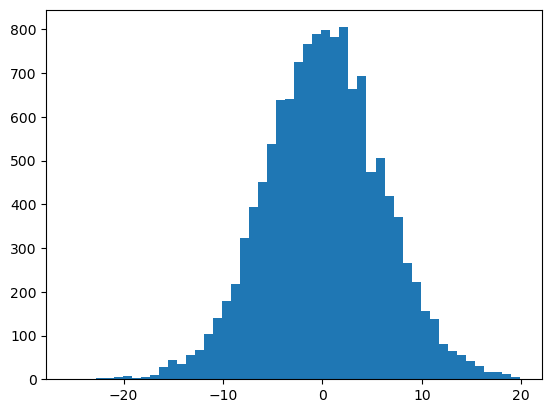

In [9]:
plt.hist(hpreact.view(-1).tolist(),50);

Notice that, even though our values follow a standard bell curve, the curve has a lot of spread. However, these values will then be fed into the function tanh(x). Looking at the graph below and we see that any value whose absolute value is 2.5 will become practically the same value.

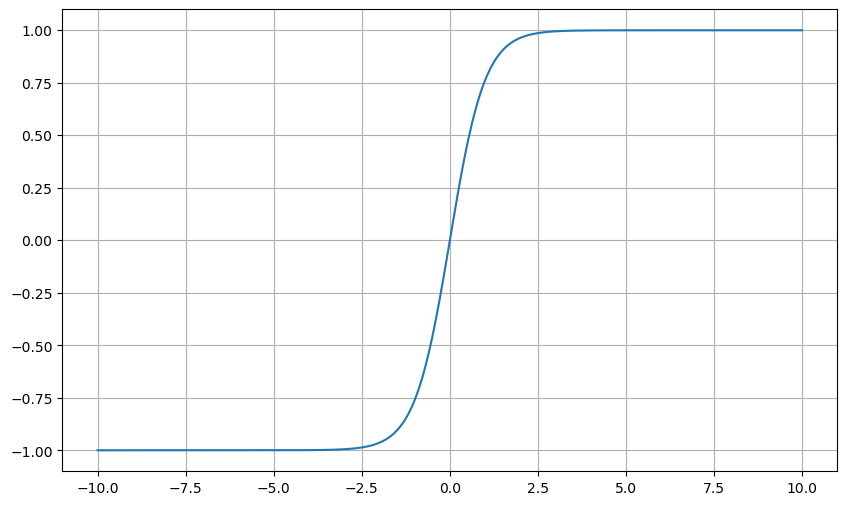

In [10]:
x = np.linspace(-10, 10, 400)
# Calculate the tanh of x
y = np.tanh(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='tanh(x)')
plt.grid(True)
plt.show()

This signifigantly alters are distribution of values in our hidden layer to what you see below. 

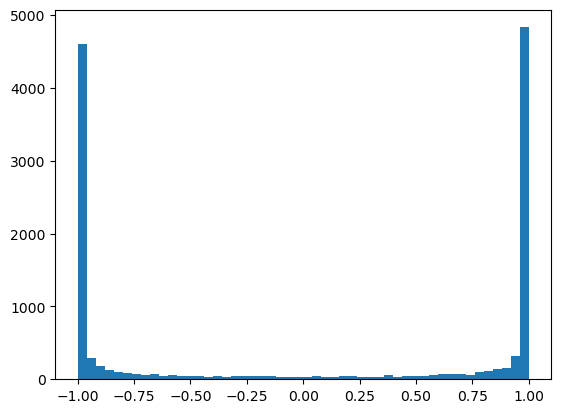

In [11]:
plt.hist(h.view(-1).tolist(),50);

This distribution is a significant problem for two reaons. One, we will show in a second that is causes high loss. However, there is perhaps an even larger problem recall that the derivative of tanh(x) is $1 - \tanh(x)^2$. Thus if $tanh(x) = 1, -1$ then we get a derivative of $0$. This however, since all of our learning happens by subtracting a multiple of the derivate, this means learning can be limited and we risk running a senario where an entire neuron is not learning. The igure below shows this. Every white spot is a spot where the derivative is 0. Each column represents a neuron. If a column is completely white, then the neuron is not able to learn and improve. 

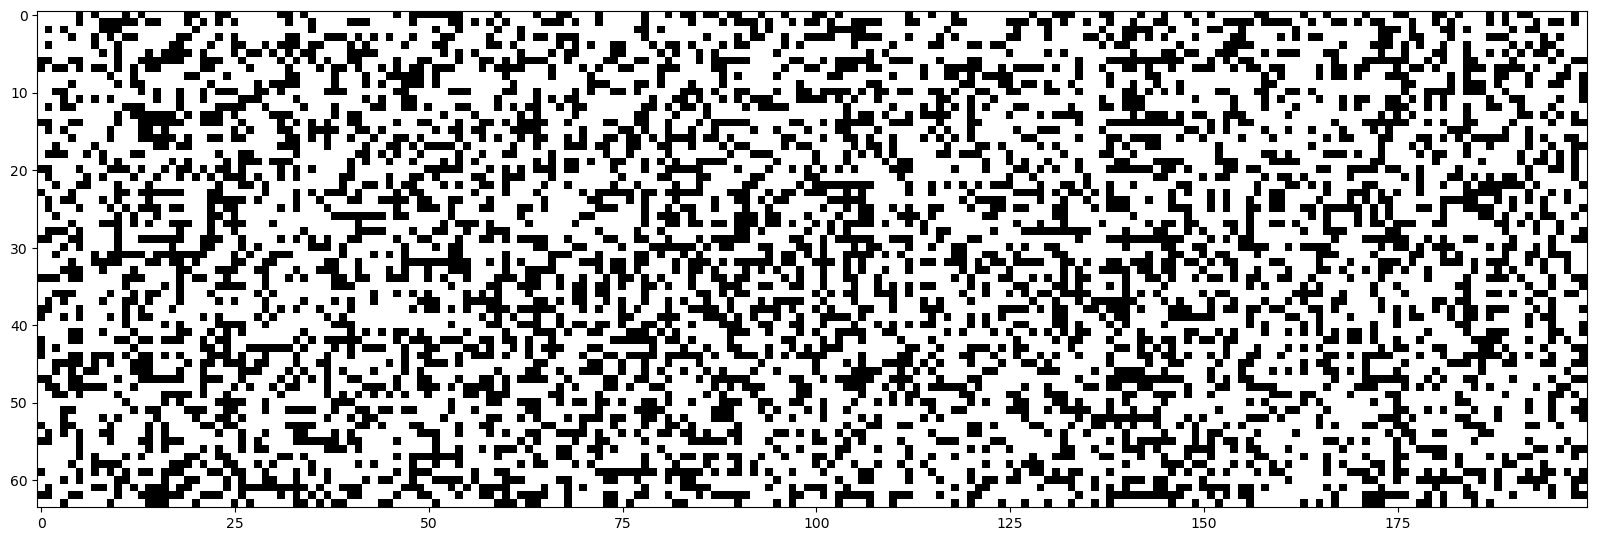

In [12]:
plt.figure(figsize=(20,10)) 
plt.imshow(h.abs()>.99, cmap= 'grey', interpolation = 'nearest')

As we can see above, we are close to killing some neurons from the get go and bottlenecking our model.

Now, we return to show why this also causes large loss in the example below

#### Example

In [13]:
logits = torch.randn(4)*10
probss = torch.softmax(logits, dim = 0)

In [14]:
loss = -probss.log().mean()
logits, probss, loss

(tensor([ -8.9399, -12.1410,  -6.1201,  -5.9152]),
 tensor([0.0260, 0.0011, 0.4368, 0.5361]),
 tensor(2.9873))

Notice that the larger you make the multiplier, the larger the loss is. The reason for this is the different between the inputs become very large. We then exponentiate these inputs, making the difference even more pronounced. This carries over even after we normalize. This leads to a large disparity on our probabilities. Specifically, it leads to some extremely small probabilities, which contribute large loss values. Thus, we wish to avoid these extremely small probabilities upon initialization. The initial solution we give is to alter our weights and make them smaller, thus making the gaussian thinner (have a smaller standard deviation). 

### Fix #1

Our main goal now is to avoid such a drastic spread in our hidden layer. To do this, want to lower the spread in our weights such that our prereact values are all below 2.5. As such, we want all of our prereact values to shrink by a factor of 10ish (view histogram if you wish to see where this number is coming from)

In [15]:
hiddenlayersize = 200                                                    #this is our m in the paragraph above
dimension = 10                                                           #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize)) * 0.1          #first weight function
b1 = torch.randn((1,hiddenlayersize                    )) * 0.1          #first bias function
W2 = torch.randn((hiddenlayersize, 27                  ))                #second weight function
b2 = torch.randn((27                                   ))                #second bias function
Parameters = [C, W1, b1, W2, b2]                                         #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [16]:
runs = 1

In [17]:
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/      1: 14.7712


Notice that making that this change cut our initial lost in about half. We observe the changes to our distrubtions below.

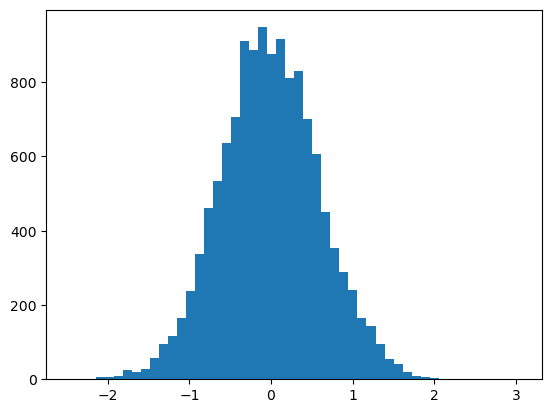

In [18]:
plt.hist(hpreact.view(-1).tolist(),50);

Notice that no values have an absolute value of 2.5 or higher. This means that none of our neurons after activating wille take a value of 1 or negative 1 as seen below

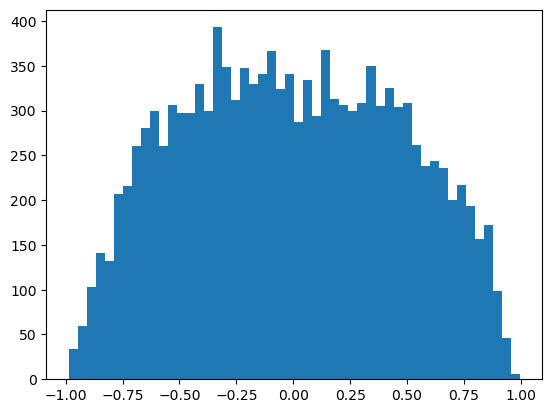

In [19]:
plt.hist(h.view(-1).tolist(),50);

This means that none of our neurons should be even close to dead. Thus we our simple change has killed two birds with one stone.

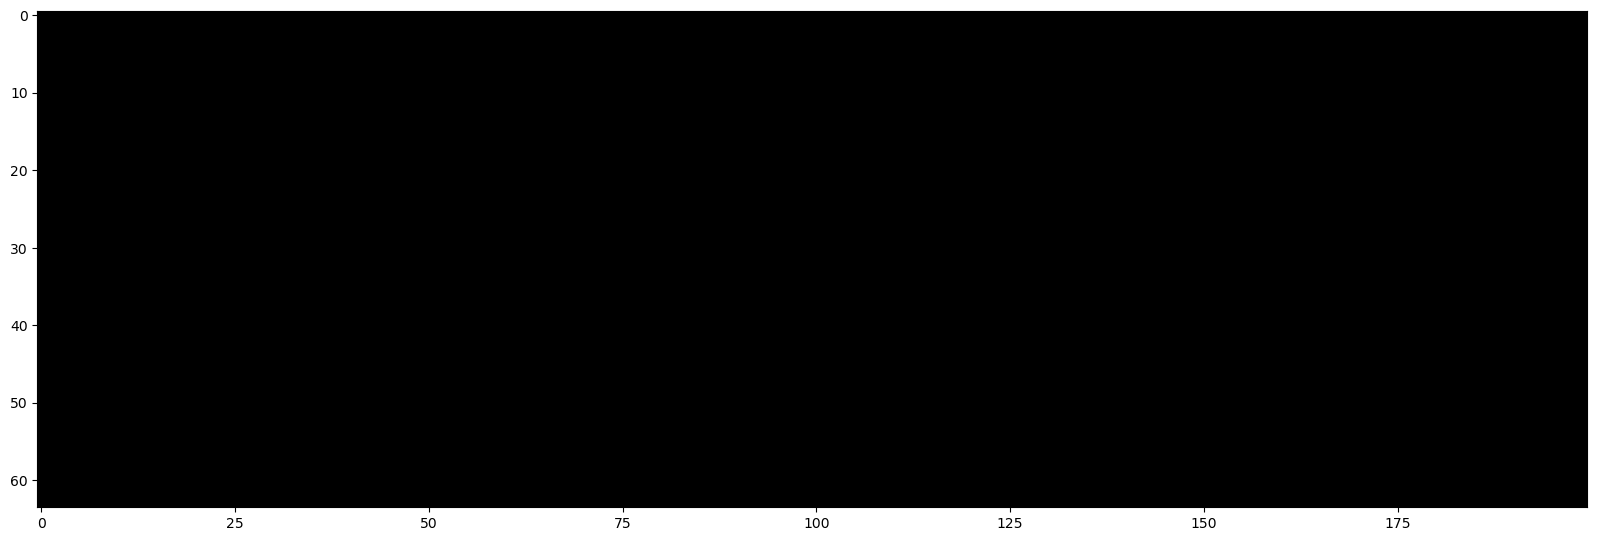

In [20]:
plt.figure(figsize=(20,10)) 
plt.imshow(h.abs()>.999, cmap= 'grey', interpolation = 'nearest')

Despite our progress however, we are still a far cry from an initial loss of 3.2

### Fix #2
So the question is now what else can be causing our high initial loss. The clearest place to look is looking at the value of h@W2+b2.

In [21]:
h@W2+b2

tensor([[-0.7849, 11.5440, -2.3446,  ...,  2.1112, -4.5335,  8.7060],
        [ 4.8280,  2.9217,  1.0214,  ..., -6.6999, -0.6351,  6.7460],
        [-8.8076,  2.2315, -5.2638,  ..., -5.5253,  0.6638, 12.0926],
        ...,
        [ 3.6896,  4.3176,  2.5125,  ...,  2.1835,  5.4291,  5.8443],
        [ 0.6601, -1.5321,  2.4067,  ..., 17.7928, -8.9591,  7.3268],
        [ 1.9569,  2.2253, -4.0046,  ..., -6.5369,  5.1266,  9.6067]],
       grad_fn=<AddBackward0>)

In looking here, we see we have a high range of values. Like before, this leads to an increase in our loss function. As such, we want our spread of h@W2+b2 to be reduced. The clearest way to do this is by limiting the spread of W2 and B2. We do as such below

In [22]:
hiddenlayersize = 200                                                    #this is our m in the paragraph above
dimension = 10                                                           #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize)) * 0.1          #first weight function
b1 = torch.randn((1,hiddenlayersize                    )) * 0.1          #first bias function
W2 = torch.randn((hiddenlayersize, 27                  )) * 0.1          #second weight function
b2 = torch.randn((27                                   )) * 0.1          #second bias function
Parameters = [C, W1, b1, W2, b2]                                         #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [23]:
runs = 1

In [24]:
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/      1: 3.4157


This simple change has brought us extremely close to our goal of a loss of 3.2. The loss obtained by these changes is now an acceptable place to start

### A new starting point
We now view how these changes affect our loss after 60,000 runs. We encourage the reader to compare this loss to the loss achieved at the end of the last notebook

In [25]:
runs = 60000

In [26]:
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/  60000: 3.1491
  10000/  60000: 1.8925
  20000/  60000: 1.7953
  30000/  60000: 1.9931
  40000/  60000: 2.1941
  50000/  60000: 1.9185


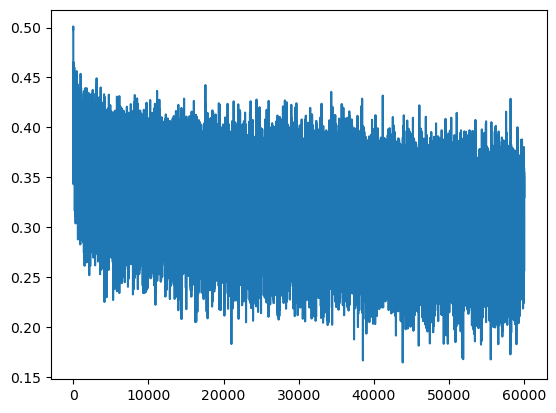

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'Test': (Xtst, Ytst),
    }[split]
    emb = C[x]
    h= torch.tanh(emb.view(emb.shape[0], block_size*dimension) @ W1+b1)
    loss = F.cross_entropy((h@W2+b2),y)
    print(split, loss.item())        

In [29]:
split_loss('train')
split_loss('val')

train 2.0032143592834473
val 2.080773115158081


Our loss is lower than our last notebook by a measurable amount. The take away is with proper initialization, we can achieve low loss much quicker than before

### What's Next

In this example we hard coded our scales by looking at histograms. However, in general, with larger models that have many layers, this process is time consuming and not something we wish to do manually. We want to explore how we can automatically retrive the scales on our weights so that our initialize is "good".

Recall our goal was to obtain a certain spread of data. In order to do this, we want to alter our standard deviation. To this end, we want to look at the following formula
>$\sigma = \frac{gain}{\sqrt{(fan mode)}}$

It turns out each non-linear function has a gain value. We can see these values at the following link
> https://pytorch.org/docs/stable/nn.init.html

For us, our non-linear function in the hidden layer is $\tanh$ which has a gain value of $\frac{5}{3}$. 

For fan mode, this is the inner dimension in our matrix multiplication preactivation step. In otherwords 
> fan mod = block_size * dimension
As such, we alter our initialization as for W1

In [30]:
hiddenlayersize = 200                                                                                   #this is our m in the paragraph above
dimension = 10                                                                                          #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                                               #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize)) * (5/3)/(block_size*dimension)**0.5           #first weight function
b1 = torch.randn((1,hiddenlayersize                    )) * 0.1                                         #first bias function
W2 = torch.randn((hiddenlayersize, 27                  )) * 0.1                                         #second weight function
b2 = torch.randn((27                                   )) * 0.1                                         #second bias function
Parameters = [C, W1, b1, W2, b2]                                                                        #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [31]:
runs = 60000

In [32]:
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/  60000: 3.5194
  10000/  60000: 2.1194
  20000/  60000: 2.1616
  30000/  60000: 1.9400
  40000/  60000: 1.8887
  50000/  60000: 1.8872


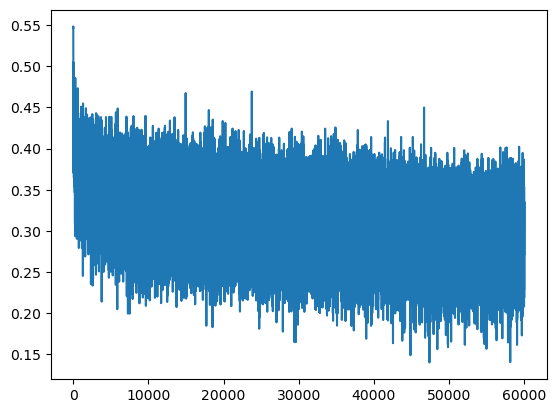

In [33]:
plt.plot(lossi)

In [34]:
split_loss('train')
split_loss('val')

train 1.9598628282546997
val 2.0622804164886475


Here we got slightly better losses and did not have to use any "magic numbers" that required us to inspect histograms. While the improvement is mostly likely due to natural variance in the learning process, this shows we can still get to the same place without requiring close inspection like before. However, we will now explore why the percise setting is not terribly important

### Batch Normalization

If our goal for after the hidden state is to have a gaussian distribution, a natural question arises: Why not just normalize the data? It turns out we can do this, as the process is differentiable. Recall standardizing a set requires the following formula

>$S = \frac{\sum_{s \in S} (s - \mu_s)}{\sigma_S}$

where $\mu_s$ is the average of $S$ and $\sigma_S$ is the standard deviation of $S$. The idea being that we can do this rather than changing/altering the weight of W1. The naive way to implement this is to just add a line of code to our loop as follows:

In [35]:
hiddenlayersize = 200                                                                                   #this is our m in the paragraph above
dimension = 10                                                                                          #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                                               #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize)) * (5/3)/(block_size*dimension)**0.5           #first weight function
b1 = torch.randn((1,hiddenlayersize                    )) * 0.1                                         #first bias function
W2 = torch.randn((hiddenlayersize, 27                  )) * 0.1                                         #second weight function
b2 = torch.randn((27                                   )) * 0.1                                         #second bias function

Parameters = [C, W1, b1, W2, b2]                                                                        #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [36]:
runs = 60000 
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    hpreact = (hpreact - hpreact.mean(0, keepdim = True))/(hpreact.std(0, keepdim = True)) #We added this line
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/  60000: 3.9457
  10000/  60000: 2.3110
  20000/  60000: 2.0613
  30000/  60000: 2.0399
  40000/  60000: 2.2334
  50000/  60000: 2.1326


In [37]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'Test': (Xtst, Ytst),
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
    hpreact = (hpreact - hpreact.mean(0, keepdim = True))/(hpreact.std(0, keepdim = True))
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),y)
    print(split, loss.item())    

In [38]:
split_loss('train')
split_loss('val')

train 2.0008039474487305
val 2.0712661743164062


Notice, the result is worse? The problem is we only want to normalize on initialization. Part of the neural network learning is to influence the distribution of the weights, however, this step does not really allow this in practicality. As such, we introduce a component called "Scale and Shift"

In [39]:
hiddenlayersize = 200                                                                                   #this is our m in the paragraph above
dimension = 10                                                                                          #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                                               #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize)) * (5/3)/(block_size*dimension)**0.5           #first weight function
b1 = torch.randn((1,hiddenlayersize                    )) * 0.1                                         #first bias function
W2 = torch.randn((hiddenlayersize, 27                  )) * 0.1                                         #second weight function
b2 = torch.randn((27                                   )) * 0.1                                         #second bias function

bngain = torch.ones((1,hiddenlayersize))
bnbias = torch.zeros((1,hiddenlayersize))

Parameters = [C, W1, b1, W2, b2, bngain, bnbias]                                                        #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [40]:
runs = 60000 #Because we dont really want to run this yet
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim = True))/(hpreact.std(0, keepdim = True)) + bnbias #We added this line
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/  60000: 3.8154
  10000/  60000: 2.3292
  20000/  60000: 2.0267
  30000/  60000: 1.6601
  40000/  60000: 2.0207
  50000/  60000: 1.9338


In [41]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'Test': (Xtst, Ytst),
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
    hpreact = bngain*(hpreact - hpreact.mean(0, keepdim = True))/(hpreact.std(0, keepdim = True)) + bnbias
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),y)
    print(split, loss.item())    

In [42]:
split_loss('train')
split_loss('val')

train 1.9980831146240234
val 2.0721898078918457


The difference is small. However, it scales with the size of the network. That is to say if our network was larger, the improvement would also be larger. However, now we have a different issue to resolve. Our model currently expects a batch input. So how do we use it to output predictions if we arent feeding it batches? To fix this, we want to calculate the entire set's mean and standard deviation a single time after training

In [43]:
with torch.no_grad():
    emb = C[Xtr]
    hpreact = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim=True)

We alter our loss function with this in mind

In [44]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'Test': (Xtst, Ytst),
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
    hpreact = bngain*(hpreact - bnmean)/(bnstd) + bnbias
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),y)
    print(split, loss.item())    

In [45]:
split_loss('train')
split_loss('val')

train 1.9980831146240234
val 2.0720229148864746


The results are almost identical, but we can now feed in a single example for predictive output. Now, it would be nice if rather than running an extra step to estimate the mean and standard deviation if we could somehow estimate it during our training loop. We do this below.

In [46]:
hiddenlayersize = 200                                                                                   #this is our m in the paragraph above
dimension = 10                                                                                          #this is dim in the paragraph above
C = torch.randn((27,dimension                          ))                                               #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize)) * (5/3)/(block_size*dimension)**0.5           #first weight function
b1 = torch.randn((1,hiddenlayersize                    )) * 0.1                                         #first bias function
W2 = torch.randn((hiddenlayersize, 27                  )) * 0.1                                         #second weight function
b2 = torch.randn((27                                   )) * 0.1                                         #second bias function

bngain = torch.ones((1,hiddenlayersize))
bnbias = torch.zeros((1,hiddenlayersize))
bnmean_running = torch.zeros((1,hiddenlayersize))
bnstd_running = torch.ones((1,hiddenlayersize))

Parameters = [C, W1, b1, W2, b2, bngain, bnbias]                                                        #list of all parameters
for p in Parameters:
    p.requires_grad = True

In [47]:
runs = 60000 #Because we dont really want to run this yet
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))

    #forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], block_size*dimension)
    hpreact = embcat @W1+b1
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain*(hpreact - bnmeani)/(bnstdi) + bnbias #We added this line
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])
    with torch.no_grad():
            bnmean_running = (0.999*bnmean_running + 0.001*bnmeani)
            bnstd_running = (0.999*bnstd_running + 0.001*bnstdi)


    #backward pass
    for p in Parameters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/  60000: 3.7451
  10000/  60000: 2.0968
  20000/  60000: 2.2813
  30000/  60000: 2.2633
  40000/  60000: 1.7728
  50000/  60000: 1.8818


We make a quick note on a slight inefficency. Our first set of biases b1 are not actually doing anything. When we subtract bnmeani, we end up just subtracting away our b1. Thus, it is best to get rid o b1 and just us bnbias as our first layer biases. 

In [48]:
with torch.no_grad():
    emb = C[Xtr]
    hpreact = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim=True)

In [49]:
bnmean

tensor([[-1.0112e+00, -5.8207e-01, -1.7344e+00, -1.4134e+00,  7.1756e-01,
         -6.8466e-01,  2.0068e+00,  1.3689e-01,  1.0447e+00, -1.3320e+00,
          8.6480e-01,  7.2306e-01, -4.2395e-01, -1.0949e+00, -3.5278e-01,
          6.5778e-01,  4.3624e-01, -3.6961e-01, -1.7828e-03, -4.9428e-01,
          3.1737e-02, -3.2540e+00, -2.9593e+00, -1.0410e+00,  1.1624e+00,
          1.0551e+00,  2.9112e+00,  4.9757e-01,  2.6882e-02, -2.4922e-01,
         -4.9656e-01, -6.8568e-01, -6.6579e-01, -1.9220e-01,  1.1876e+00,
          6.1279e-01,  3.2400e+00, -9.1828e-01,  1.1902e+00, -2.0163e-01,
         -2.6083e-01,  2.5246e-01,  1.0958e+00, -1.2706e-01,  3.5870e-01,
         -1.7251e+00, -8.9377e-02, -7.3057e-01,  1.4556e+00,  4.4257e-01,
         -1.8310e+00, -3.9649e+00, -7.0188e-03,  3.4613e-01, -7.6906e-01,
          9.8300e-01,  6.9740e-01, -8.7848e-01, -6.0833e-01,  1.5021e-01,
          9.3774e-01, -2.7035e+00,  1.7707e+00,  1.9136e-01, -1.3941e+00,
         -2.4774e+00,  2.0444e+00,  4.

In [50]:
bnmean_running

tensor([[-1.0065e+00, -5.8517e-01, -1.7234e+00, -1.4119e+00,  7.1940e-01,
         -6.8748e-01,  1.9981e+00,  1.3451e-01,  1.0432e+00, -1.3288e+00,
          8.8271e-01,  7.1595e-01, -4.2936e-01, -1.0914e+00, -3.5975e-01,
          6.5737e-01,  4.3637e-01, -3.6508e-01,  1.2529e-02, -4.9631e-01,
          4.6837e-02, -3.2612e+00, -2.9614e+00, -1.0402e+00,  1.1611e+00,
          1.0453e+00,  2.9053e+00,  4.9525e-01,  3.9125e-02, -2.3840e-01,
         -4.9789e-01, -6.8567e-01, -6.5667e-01, -1.9279e-01,  1.1891e+00,
          6.2015e-01,  3.2405e+00, -9.1990e-01,  1.1897e+00, -1.9727e-01,
         -2.5988e-01,  2.6240e-01,  1.0947e+00, -1.3015e-01,  3.5548e-01,
         -1.7314e+00, -9.2518e-02, -7.3388e-01,  1.4566e+00,  4.4634e-01,
         -1.8300e+00, -3.9679e+00,  5.0691e-03,  3.4859e-01, -7.7585e-01,
          9.7668e-01,  6.9001e-01, -8.7859e-01, -6.1839e-01,  1.4630e-01,
          9.2481e-01, -2.7044e+00,  1.7588e+00,  1.9788e-01, -1.3903e+00,
         -2.4645e+00,  2.0441e+00,  4.

Comparing our means, we can tell they are very similar. While there are some differences, the convience of not needing to run a second step is worth it. This means we can redefine our loss function to the following

In [51]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'Test': (Xtst, Ytst),
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
    hpreact = bngain*(hpreact - bnmean_running)/(bnstd_running) + bnbias
    h= torch.tanh(hpreact)
    loss = F.cross_entropy((h@W2+b2),y)
    print(split, loss.item())    

In [52]:
split_loss('train')
split_loss('val')

train 2.0042366981506348
val 2.072596549987793


### A standard Pytorch deep model

Here we build a deeper learning network that look much closer to what a standard pytorch model would look like.

In [53]:
#Creation of a Linear Layer
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**.5
        self.bias = torch.zeros (fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias 
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [54]:
#Creation of a Batch-Normalization Layer
class BatchNorm1d:
    def __init__(self, dim, epsilon = 1e-5, momentum = 0.1):
        self.eps = epsilon
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.runningMean = torch.zeros(dim)
        self.runningVar = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xMean = x.mean(0, keepdim = True)
            xVar = x.var(0, keepdim = True, unbiased = True)
        else:
            xMean = self.runningMean
            xVar = self.runningVar
        xhat = (x - xMean)/torch.sqrt(xVar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad:
                self.runningMean = (1-self.momentum)*self.runningMean + self.momentum *xMean
                self.runningVar = (1-self.momentum)*self.runningVar + self.momentum *xVar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [55]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return(self.out)
    def parameters(self):
        return [] 

In [56]:
n_embd = 10
n_hidden = 100

C = torch.randn((vocabsize, n_embd))
layers = [
    Linear(n_embd * block_size,  n_hidden), Tanh(),
    Linear(n_hidden           ,  n_hidden), Tanh(),
    Linear(n_hidden           ,  n_hidden), Tanh(),
    Linear(n_hidden           ,  n_hidden), Tanh(),
    Linear(n_hidden           ,  n_hidden), Tanh(),
    Linear(n_hidden           , vocabsize), 
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47497


In [69]:
runs = 60000 #Because we dont really want to run this yet
lossi = []
stepi = []
batchsize = 64

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (batchsize,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], block_size*dimension)

    for layer in layers:
         x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    # for layer in layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = .316 - .316*k/runs
    for p in parameters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

    if k %10000 == 0:
        print(f'{k:7d}/{runs:7d}: {loss.item():.4f}')

      0/  60000: 3.1822
  10000/  60000: 2.3503
  20000/  60000: 1.9865
  30000/  60000: 1.8565
  40000/  60000: 2.1392
  50000/  60000: 1.9921


In [73]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'Test': (Xtst, Ytst),
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0], block_size*dimension)
    for layer in layers:
        hpreact = layer(hpreact)
    loss = F.cross_entropy(hpreact, y)
    print(split, loss.item())    

In [74]:
split_loss('train')
split_loss('val')

train 1.8314120769500732
val 2.047428846359253


In [77]:
for i in range(20):
    out = ''
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h= torch.tanh(emb.view(emb.shape[0], -1))
        for layer in layers:
            h = layer(h)
        probs = F.softmax(h, dim = 1)
        ix = torch.multinomial(probs, num_samples =1 ).item()
        context = context[1:]+[ix]
        if ix ==0:
            break
        out += itos[ix]
    print(out)

loki
caidenya
jacenzo
bey
jhadya
alen
kayson
hayitanay
kasvi
rhean
morn
maydi
carlenion
albeima
angika
wor
enon
trevole
riyanylin
tristia
